# Modeling

## 0. Import Dependencies

In [363]:
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold 
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    mean_squared_error, r2_score, mean_absolute_error
)
#!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
#!pip install shap
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA

import joblib

import warnings
warnings.filterwarnings('ignore')



In [364]:
SEED = 42
np.random.seed(SEED)

## 1. Set Up


In [365]:
BASE_DIR = Path(r"C:/Users/black/Documents/Ironhack/final_project")
FEATENG_DIR = BASE_DIR / "data" / "feat_eng"
MODELS_DIR = BASE_DIR / "data" / "models"

FEATENG_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

## 2. Load Data

In [366]:
individual_df = pd.read_csv(r"data\feat_eng\ind_df_final.csv")
violence_df_all = pd.read_csv(r"data\feat_eng\violence_df_final_all")
violence_df_fe_X = pd.read_csv(r"data\feat_eng\violence_df_final_fe_X")
violence_df_fe_y = pd.read_csv(r"data\feat_eng\violence_df_final_fe_y")
global_df = pd.read_csv(r"data\feat_eng\global_df_final")

## 3. Individual Dataset 

**Target Variable** : violence (yes/no == 1/0)

*Why Her? What makes a women vulnerable to violence?*

### 3.1 Overview Dataset 

In [367]:
individual_df.head()

,education_ordinal,is_married,emp_unemployed,age_scaled,income_scaled,vawg_rate,young_unmarried,low_education_unemployed,married_unemployed,age_income,...,age_group_young,age_group_middle,economic_vulnerability,empowerment_score,high_vawg_environment,emp_employed,emp_semi employed,violence,married_low_income,young_unemployed
0,2,0,False,-1.370578,2.524408,17.350361,1,0,0,-3.459898,...,1,0,0,3,0,True,False,0,0,0
1,2,1,False,-0.955928,2.747221,17.350361,0,0,0,-2.626145,...,1,0,0,3,0,True,False,0,0,0
2,2,1,False,-0.852265,2.654744,17.350361,0,0,0,-2.262546,...,1,0,0,3,0,True,False,0,0,0
3,2,0,False,-0.748603,2.007143,17.350361,1,0,0,-1.502553,...,1,0,0,3,0,True,False,0,0,0
4,1,1,False,-0.644940,2.654744,23.165181,0,0,0,-1.712152,...,0,1,1,2,1,True,False,0,0,0


In [368]:
individual_df.shape

(325, 21)

<Axes: xlabel='violence'>

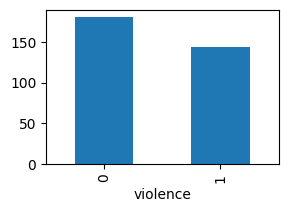

In [369]:
# check if balanced or not
individual_df["violence"].value_counts().plot(kind="bar", figsize=(3,2))

# --> inbalanced data

### 3.2 Base Model

#### Train Test Split

In [370]:
# prepare data
X_id = individual_df.drop(columns=['violence'])
y_id = individual_df['violence']

# train-test split (stratified for imbalanced data)
X_train_id, X_test_id, y_train_id, y_test_id = train_test_split(X_id, y_id, test_size=0.2, random_state=42, stratify=y_id)

print(f"\nTraining set size: {len(X_train_id)}")
print(f"Test set size: {len(X_test_id)}")



Training set size: 260
Test set size: 65


#### Logistic Regression

In [371]:
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train_id, y_train_id)
    
# Predictions
y_pred_lr = lr.predict(X_test_id)
y_pred_proba_lr = lr.predict_proba(X_test_id)[:, 1]
    
# Evaluation
print("\nClassification Report (Logistic Regression, Individual Dataset):")
print(classification_report(y_test_id, y_pred_lr))
print(f"ROC-AUC Score: {roc_auc_score(y_test_id, y_pred_proba_lr):.3f}")
    
# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'feature': X_id.columns,
    'coefficient': lr.coef_[0],
    'abs_coefficient': np.abs(lr.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
print("\nTop 10 Most Important Features (Logistic Regression, Individual Dataset)):")
print(feature_importance_lr.head(10))



Classification Report (Logistic Regression, Individual Dataset):
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        36
           1       0.84      0.93      0.89        29

    accuracy                           0.89        65
   macro avg       0.89      0.90      0.89        65
weighted avg       0.90      0.89      0.89        65

ROC-AUC Score: 0.961

Top 10 Most Important Features (Logistic Regression, Individual Dataset)):
                     feature  coefficient  abs_coefficient
3                 age_scaled     2.418271         2.418271
12          age_group_middle    -2.035021         2.035021
13    economic_vulnerability     0.680444         0.680444
19          young_unemployed     0.529172         0.529172
14         empowerment_score    -0.304886         0.304886
0          education_ordinal    -0.280119         0.280119
15     high_vawg_environment    -0.239251         0.239251
7   low_education_unemployed     0.219

#### Random Forest

In [372]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
    )
rf.fit(X_train_id, y_train_id)
    
# Predictions
y_pred_rf = rf.predict(X_test_id)
y_pred_proba_rf = rf.predict_proba(X_test_id)[:, 1]
    
# Evaluation
print("\nClassification Report (Random Forest, Individual Dataset):")
print(classification_report(y_test_id, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test_id, y_pred_proba_rf):.3f}")
    
# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': X_id.columns,
    'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
print("\nTop 10 Most Important Features (Random Forest, Individual Dataset):")
print(feature_importance_rf.head(10))



Classification Report (Random Forest, Individual Dataset):
              precision    recall  f1-score   support

           0       0.97      0.81      0.88        36
           1       0.80      0.97      0.88        29

    accuracy                           0.88        65
   macro avg       0.88      0.89      0.88        65
weighted avg       0.89      0.88      0.88        65

ROC-AUC Score: 0.977

Top 10 Most Important Features (Random Forest, Individual Dataset):
                     feature  importance
3                 age_scaled    0.392460
9                 age_income    0.150382
5                  vawg_rate    0.071882
12          age_group_middle    0.062221
14         empowerment_score    0.058103
7   low_education_unemployed    0.046618
0          education_ordinal    0.045736
13    economic_vulnerability    0.042846
11           age_group_young    0.024158
10          education_income    0.023512


#### Model COmparison

In [373]:
cv_lr = cross_val_score(lr, X_train_id, y_train_id, cv=5, scoring='roc_auc')
cv_rf = cross_val_score(rf, X_train_id, y_train_id, cv=5, scoring='roc_auc')
    
print(f"Logistic Regression Individual Dataset CV ROC-AUC: {cv_lr.mean():.3f} (+/- {cv_lr.std():.3f})")
print(f"Random Forest Individual Dataset CV ROC-AUC:       {cv_rf.mean():.3f} (+/- {cv_rf.std():.3f})")

Logistic Regression Individual Dataset CV ROC-AUC: 0.927 (+/- 0.022)
Random Forest Individual Dataset CV ROC-AUC:       0.977 (+/- 0.025)


### 3.3 Data Check fro Optimization


In [374]:
X_num = individual_df.select_dtypes(include=['float', 'int']).drop(columns=['violence'])

vif_data = pd.DataFrame()
vif_data['feature'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i) 
                   for i in range(X_num.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))


                     feature          VIF
13         empowerment_score  2268.056143
0          education_ordinal  1810.962373
4                  vawg_rate   448.131896
12    economic_vulnerability   424.945757
7         married_unemployed   283.250932
15        married_low_income   259.556358
6   low_education_unemployed   101.895619
1                 is_married    92.089764
3              income_scaled    88.421376
10           age_group_young    28.376833
16          young_unemployed    18.766874
9           education_income    17.888116
5            young_unmarried     8.581228
14     high_vawg_environment     8.308161
11          age_group_middle     7.281218
2                 age_scaled     6.461950
8                 age_income     1.980847


In [375]:
# signal strength test target 
dummy_r = DummyRegressor(strategy="mean")
dummy_r.fit(X_train_id, y_train_id)
dummy_r.score(X_test_id, y_test_id)


-5.986590038298267e-05

### 3.4 Optimized Model

In [376]:
def individual_model_optimized(df, target='violence'):
    
    X = df.drop(columns=[target])
    y = df[target]

    # One-hot encode
    X = pd.get_dummies(X, drop_first=True)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Handle Imbalance Using SMOTE
    sm = SMOTE(random_state=42, k_neighbors=3)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # Logistic Regression with ElasticNet
    # simultaneously drops multicollinearity and stabilizes noisy signals
    model = LogisticRegressionCV(
        cv=5,
        penalty="elasticnet",
        solver="saga",
        l1_ratios=[0.1, 0.5, 0.7, 0.9],
        scoring="roc_auc",
        max_iter=5000,
        class_weight="balanced"
    )
    model.fit(X_train_res, y_train_res)

    # Threshold-independent performance
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

    # Feature Importance (non-zero coeffs)
    coefs = pd.Series(model.coef_.ravel(), index=X.columns)
    selected = coefs[coefs != 0].sort_values(key=abs, ascending=False)

    print("\nSelected Features:")
    print(selected)

    feature_names = X.columns
    joblib.dump(feature_names, MODELS_DIR / "individual_feature_names.pkl")
    joblib.dump(selected, MODELS_DIR / "individual_selected_features.pkl")

    return model

In [377]:
individual_model_optimized(individual_df, target='violence')


Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.93      0.93      0.93        29

    accuracy                           0.94        65
   macro avg       0.94      0.94      0.94        65
weighted avg       0.94      0.94      0.94        65

ROC-AUC: 0.954

Selected Features:
age_group_middle         -2.212307
age_scaled                2.041950
economic_vulnerability    0.529836
income_scaled            -0.348490
empowerment_score        -0.284754
vawg_rate                 0.061005
dtype: float64


,Cs,10
,fit_intercept,True
,cv,5
,dual,False
,penalty,'elasticnet'
,scoring,'roc_auc'
,solver,'saga'
,tol,0.0001
,max_iter,5000
,class_weight,'balanced'
,n_jobs,None


In [378]:
# helper function to predict on new dataset
def predict_individual(model_dict, df_new):
    model = model_dict["model"]
    feature_names = model_dict["feature_names"]

    # One-hot encode new data
    X_new = pd.get_dummies(df_new, drop_first=True)

    # Align columns (add missing columns as zeros)
    X_new = X_new.reindex(columns=feature_names, fill_value=0)

    # Predict probability of violence
    return model.predict_proba(X_new)[:, 1]


## 4. Violence Dataset

**Target Variable** : Intimate Partner Violenc (ipv, continous)
- composite only (reduce overfitting)
- compare models: Linear regression vs Random Forest vs XGBoost
-  *Cultural Context: Which societal attitudes predict higher IPV rates?*

### 4.1 Overview Dataset

In [379]:
# only features
violence_df_fe_X.head()

,structural_inequality_index,violence_exposure_index,general_danger_index,economic_empowerment_gap,inequality_attitudes_interaction,education_attitudes_interaction,legal_violence_interaction
0,-0.964292,0.152586,0.903442,0.800470,-0.789501,0.005758,0.387501
1,-0.064801,-0.187819,0.111532,-0.261881,0.079435,0.757695,0.098490
2,1.960851,-2.058809,-0.600209,-0.780153,-2.403674,0.901379,2.010315
3,1.781760,-0.874997,-0.724152,-0.707869,-1.131737,0.442243,0.370937
4,1.747599,-0.510202,-0.277318,-0.531493,-1.110039,0.132028,0.267543


In [380]:
violence_df_fe_X.shape

(50, 7)

In [381]:
# only target 
violence_df_fe_y.head()

,ipv
0,30.0
1,73.0
2,38.0
3,29.0
4,53.0


### 4.2 Train Test Split

In [382]:
#X_vd = violence_df_fe_X
#y_vd = violence_df_fe_y

# Train-test split
#X_train_vd, X_test_vd, y_train_vd, y_test_vd = train_test_split(X_vd, y_vd, test_size=0.2, random_state=42)

#print(f"\nTraining set size: {len(X_train_vd)}")
#print(f"Test set size: {len(X_test_vd)}")


In [383]:
X_vd = violence_df_all.drop(columns=["ipv", "country"])
y_vd = violence_df_all["ipv"]

X_train_vd, X_test_vd, y_train_vd, y_test_vd = train_test_split(X_vd, y_vd, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(X_train_vd)}")
print(f"Test set size: {len(X_test_vd)}")


Training set size: 40
Test set size: 10


### 4.3 Base Models

#### Ridge Regression

In [384]:
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_vd, y_train_vd)
    
# Predictions
y_pred_ridge = ridge.predict(X_test_vd)
    
# Evaluation
r2_ridge = r2_score(y_test_vd, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test_vd, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test_vd, y_pred_ridge)
    
print(f"R² Score: {r2_ridge:.3f}")
print(f"RMSE: {rmse_ridge:.3f}")
print(f"MAE: {mae_ridge:.3f}")
    
# Feature importance
feature_importance_ridge = pd.DataFrame({
    'feature': X_vd.columns,
    'coefficient': ridge.coef_,
    'abs_coefficient': np.abs(ridge.coef_)
}).sort_values('abs_coefficient', ascending=False)
    
print("\nTop Features (Ridge):")
print(feature_importance_ridge.head(7))


R² Score: 0.975
RMSE: 2.997
MAE: 2.465

Top Features (Ridge):
                        feature  coefficient  abs_coefficient
10      violence_exposure_index    30.024196        30.024196
9   structural_inequality_index     1.177775         1.177775
1                           atv    -0.945444         0.945444
0                           npv     0.431145         0.431145
15   legal_violence_interaction     0.219889         0.219889
5                           gii    -0.177505         0.177505
8                          wpsi     0.125586         0.125586


#### Random Forest Regressor

In [385]:
rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_split=5,
    random_state=42
)
rf_reg.fit(X_train_vd, y_train_vd)
    
# Predictions
y_pred_rf = rf_reg.predict(X_test_vd)
    
# Evaluation
r2_rf = r2_score(y_test_vd, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_vd, y_pred_rf))
mae_rf = mean_absolute_error(y_test_vd, y_pred_rf)
    
print(f"R² Score: {r2_rf:.3f}")
print(f"RMSE: {rmse_rf:.3f}")
print(f"MAE: {mae_rf:.3f}")
    
# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': X_vd.columns,
    'importance': rf_reg.feature_importances_
}).sort_values('importance', ascending=False)
    
print("\nTop Features (Random Forest):")
print(feature_importance_rf.head(7))


R² Score: 0.556
RMSE: 12.589
MAE: 10.372

Top Features (Random Forest):
                             feature  importance
10           violence_exposure_index    0.375359
4                                wdi    0.199997
0                                npv    0.086291
2                                 ld    0.050942
13  inequality_attitudes_interaction    0.044713
5                                gii    0.038642
9        structural_inequality_index    0.035799


#### Gradient Boosting

In [386]:
gbr = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train_vd, y_train_vd)
    
# Predictions
y_pred_gbr = gbr.predict(X_test_vd)
    
# Evaluation
r2_gbr = r2_score(y_test_vd, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test_vd, y_pred_gbr))
mae_gbr = mean_absolute_error(y_test_vd, y_pred_gbr)
    
print(f"R² Score: {r2_gbr:.3f}")
print(f"RMSE: {rmse_gbr:.3f}")
print(f"MAE: {mae_gbr:.3f}")
    
# Feature importance
feature_importance_gbr = pd.DataFrame({
    'feature': X_vd.columns,
    'importance': gbr.feature_importances_
}).sort_values('importance', ascending=False)
    
print("\nTop Features (Gradient Boosting):")
print(feature_importance_gbr.head(7))

R² Score: 0.522
RMSE: 13.064
MAE: 9.175

Top Features (Gradient Boosting):
                       feature  importance
10     violence_exposure_index    0.497648
4                          wdi    0.116824
0                          npv    0.108803
2                           ld    0.078187
15  legal_violence_interaction    0.042674
11        general_danger_index    0.035334
5                          gii    0.031964


#### Model Comparison

In [387]:
comparison = pd.DataFrame({
    'Model': ['Ridge', 'Random Forest', 'Gradient Boosting'],
    'R²': [r2_ridge, r2_rf, r2_gbr],
    'RMSE': [rmse_ridge, rmse_rf, rmse_gbr],
    'MAE': [mae_ridge, mae_rf, mae_gbr]
    })
print(comparison)


               Model        R²       RMSE        MAE
0              Ridge  0.974837   2.997266   2.464562
1      Random Forest  0.556087  12.588938  10.372021
2  Gradient Boosting  0.521926  13.064351   9.175448


### 4.4 Data Check for Optimization

In [388]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_num = X_vd.select_dtypes(include=['float', 'int'])

vif_data = pd.DataFrame()
vif_data['feature'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i) 
                   for i in range(X_num.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))


                             feature       VIF
3                                 ih       inf
2                                 ld       inf
5                                gii       inf
4                                wdi       inf
6                        sec_edu_gap       inf
7                      lab_force_gap       inf
9        structural_inequality_index       inf
8                               wpsi       inf
11              general_danger_index       inf
12          economic_empowerment_gap       inf
10           violence_exposure_index  8.363142
1                                atv  6.058318
0                                npv  3.136707
14   education_attitudes_interaction  2.641516
13  inequality_attitudes_interaction  2.113589
15        legal_violence_interaction  1.961367


In [389]:
# signal strength test target 
dummy_r = DummyRegressor(strategy="mean")
dummy_r.fit(X_train_vd, y_train_vd)
dummy_r.score(X_test_vd, y_test_vd)


-0.01037961121537223

In [390]:
# feature stability test 
corr_train = X_train_vd.corr()
corr_test = X_test_vd.corr()

(corr_train - corr_test).abs().mean().sort_values(ascending=False)


inequality_attitudes_interaction    0.615872
legal_violence_interaction          0.323631
npv                                 0.283140
violence_exposure_index             0.260347
education_attitudes_interaction     0.247885
lab_force_gap                       0.207476
ih                                  0.194415
ld                                  0.191893
atv                                 0.188136
wpsi                                0.183444
general_danger_index                0.169845
economic_empowerment_gap            0.167191
gii                                 0.159472
structural_inequality_index         0.150720
wdi                                 0.146200
sec_edu_gap                         0.122303
dtype: float64

### 4.5 Optimized Model

In [391]:
def violence_model_optimized(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

    loo = LeaveOneOut()

    # ElasticNet with LOOCV
    enet = ElasticNetCV(
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
        alphas=np.logspace(-4, 2, 100),
        cv=loo,
        max_iter=10000
    )
    enet.fit(X_train, y_train)

    print(f"Best alpha: {enet.alpha_:.4f}")
    print(f"Best l1_ratio: {enet.l1_ratio_:.2f}")

    preds_train = enet.predict(X_train)
    preds_test = enet.predict(X_test)
    
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)

    print(f"R² Train: {r2_train:.3f}") 
    print(f"R² Test: {r2_test:.3f}") 

    rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
    
    print(f"RMSE Train: {rmse_train:.3f}")
    print(f"RMSE Test: {rmse_test:.3f}")
    
    # Selected Features
    coefs = pd.Series(enet.coef_, index=X.columns)
    selected = coefs[coefs != 0].sort_values(key=abs, ascending=False)
    print("\nSelected Features:")
    print(selected)

    feature_names = X.columns

    return  {"model": enet, "selected": selected, "feature_names": feature_names}


In [392]:
results_violence = violence_model_optimized(X_vd, y_vd)
results_violence


Best alpha: 0.0001
Best l1_ratio: 0.90
R² Train: 1.000
R² Test: 1.000
RMSE Train: 0.008
RMSE Test: 0.013

Selected Features:
violence_exposure_index             34.739700
general_danger_index               -33.394897
wpsi                               -10.305355
gii                                  7.590312
economic_empowerment_gap            -5.748439
structural_inequality_index          2.251537
atv                                 -1.130344
sec_edu_gap                          0.668563
ih                                   0.610171
ld                                   0.604610
npv                                  0.491805
lab_force_gap                        0.303958
wdi                                  0.092182
education_attitudes_interaction      0.002167
inequality_attitudes_interaction     0.001392
legal_violence_interaction          -0.000168
dtype: float64


{'model': ElasticNetCV(alphas=array([1.00000000e-04, 1.14975700e-04, 1.32194115e-04, 1.51991108e-04,
        1.74752840e-04, 2.00923300e-04, 2.31012970e-04, 2.65608778e-04,
        3.05385551e-04, 3.51119173e-04, 4.03701726e-04, 4.64158883e-04,
        5.33669923e-04, 6.13590727e-04, 7.05480231e-04, 8.11130831e-04,
        9.32603347e-04, 1.07226722e-03, 1.23284674e-03, 1.41747416e-03,
        1.62975083e-03, 1.873817...
        7.05480231e+00, 8.11130831e+00, 9.32603347e+00, 1.07226722e+01,
        1.23284674e+01, 1.41747416e+01, 1.62975083e+01, 1.87381742e+01,
        2.15443469e+01, 2.47707636e+01, 2.84803587e+01, 3.27454916e+01,
        3.76493581e+01, 4.32876128e+01, 4.97702356e+01, 5.72236766e+01,
        6.57933225e+01, 7.56463328e+01, 8.69749003e+01, 1.00000000e+02]),
              cv=LeaveOneOut(), l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
              max_iter=10000),
 'selected': violence_exposure_index             34.739700
 general_danger_index               -33.394897
 wpsi   

In [393]:
# helper function

def predict_violence(model_dict, df_new):
    model = model_dict["model"]
    feature_names = model_dict["feature_names"]

    # Align columns of new data with model features
    X_new = df_new.reindex(columns=feature_names, fill_value=0)

    return model.predict(X_new)

## 5. Global Dataset

**Target Variable:** Intimate Partner Violence (ip_violence)
 
- supervised Learning with all Features
- *What Works? Which country-level interventions reduce violence?*


### 5.1 Overview Dataset 

In [394]:
global_df.head()

,country,economic_development_index,gender_inequality_composite,youth_vulnerability_index,freedom_index,maternal_health_risk,econ_gender_interaction,freedom_inequality_interaction,youth_compound_risk,wpsi,seats_parliament,maternal_mortality,ip_violence_missing,wpsi_missing,ip_violence
0,Afghanistan,-3.435148,2.012829,1.938100,-2.284678,1.558708,-6.914367,-4.598666,1.455041,0.286000,27.2,638.0,0,0,46.000000
1,Angola,-0.958283,1.248151,0.317290,-0.734784,1.415363,-1.196082,-0.917122,-2.584103,0.598000,29.5,241.0,0,0,38.000000
2,Albania,1.147539,-1.690309,-0.716077,0.823646,-0.704143,-1.939695,-1.392216,0.619054,0.796000,35.7,15.0,0,0,13.000000
3,Andorra,1.659922,-2.134899,-0.527925,0.826419,-0.849748,-3.543765,-1.764320,0.291153,0.846985,46.4,0.0,1,1,20.157011
4,United Arab Emirates,1.699965,-1.678001,0.247325,-0.354063,-0.879801,-2.852544,0.594118,-1.305647,0.868000,50.0,3.0,1,0,20.359459


In [395]:
global_df.shape

(195, 15)

### 5.2 Base Model

#### Train Test Split

In [396]:
# Prepare data
X_gd = global_df.drop(columns=['country', "ip_violence"])
y_gd = global_df["ip_violence"]
    
# Train-test split
X_train_gd, X_test_gd, y_train_gd, y_test_gd = train_test_split(X_gd, y_gd, test_size=0.2, random_state=42)
    
print(f"\nTraining set size: {len(X_train_gd)}")
print(f"Test set size: {len(X_test_gd)}")


Training set size: 156
Test set size: 39


#### Lasso (Feature Seletcion)

In [397]:
lasso = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso.fit(X_train_gd, y_train_gd)
    
# Predictions
y_pred_lasso = lasso.predict(X_test_gd)
    
# Evaluation
r2_lasso = r2_score(y_test_gd, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test_gd, y_pred_lasso))
    
print(f"R² Score: {r2_lasso:.3f}")
print(f"RMSE: {rmse_lasso:.3f}")
    
# Non-zero coefficients (selected features)
feature_importance_lasso = pd.DataFrame({'feature': X_gd.columns,'coefficient': lasso.coef_})
selected_features = feature_importance_lasso[feature_importance_lasso['coefficient'] != 0]
    
print(f"\nFeatures selected by Lasso: {len(selected_features)}/{len(X_gd.columns)}")
print(selected_features.sort_values('coefficient', key=abs, ascending=False))


R² Score: 0.079
RMSE: 8.489

Features selected by Lasso: 9/13
                           feature  coefficient
12                    wpsi_missing     1.970345
0       economic_development_index    -1.933671
11             ip_violence_missing    -1.536623
2        youth_vulnerability_index     0.973682
7              youth_compound_risk    -0.231000
9                 seats_parliament    -0.061758
3                    freedom_index    -0.046685
6   freedom_inequality_interaction     0.023143
10              maternal_mortality     0.014210


#### Random Forest

In [398]:
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    min_samples_split=10,
    random_state=42
)
rf_reg.fit(X_train_gd, y_train_gd)
    
# Predictions
y_pred_rf = rf_reg.predict(X_test_gd)
    
# Evaluation
r2_rf = r2_score(y_test_gd, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_gd, y_pred_rf))
    
print(f"R² Score: {r2_rf:.3f}")
print(f"RMSE: {rmse_rf:.3f}")
    
# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': X_gd.columns,
    'importance': rf_reg.feature_importances_
}).sort_values('importance', ascending=False)
    
print("\nTop 10 Features (Random Forest):")
print(feature_importance_rf.head(10))


R² Score: 0.307
RMSE: 7.366

Top 10 Features (Random Forest):
                        feature  importance
10           maternal_mortality    0.267052
0    economic_development_index    0.148236
4          maternal_health_risk    0.127429
8                          wpsi    0.126568
9              seats_parliament    0.086631
3                 freedom_index    0.061281
2     youth_vulnerability_index    0.044443
5       econ_gender_interaction    0.037861
1   gender_inequality_composite    0.036394
7           youth_compound_risk    0.033291


#### Model Comparison

In [399]:
comparison = pd.DataFrame({
    'Model': ['Lasso', 'Random Forest'],
    'R²': [r2_lasso, r2_rf],
    'RMSE': [rmse_lasso, rmse_rf]
})
print(comparison)


           Model        R²      RMSE
0          Lasso  0.079364  8.488624
1  Random Forest  0.306754  7.366092


### 5.3 Data Check for Optimization

In [400]:
# multicolinearity CHeck
X_num = global_df.select_dtypes(include=['float', 'int']).drop(columns=['ip_violence'])

vif_data = pd.DataFrame()
vif_data['feature'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i) 
                   for i in range(X_num.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))




                           feature        VIF
8                             wpsi  17.447025
9                 seats_parliament  15.104728
10              maternal_mortality  14.647931
4             maternal_health_risk  14.210212
1      gender_inequality_composite   5.787316
5          econ_gender_interaction   4.503346
6   freedom_inequality_interaction   4.038624
0       economic_development_index   3.835278
3                    freedom_index   3.701539
2        youth_vulnerability_index   2.282245
11             ip_violence_missing   1.708462
12                    wpsi_missing   1.329733
7              youth_compound_risk   1.281383


In [401]:
# signal strength test target 
dummy_r = DummyRegressor(strategy="mean")
dummy_r.fit(X_train_gd, y_train_gd)
dummy_r.score(X_test_gd, y_test_gd)


-0.04659657987468746

In [402]:
# feature stability test 
corr_train = X_train_gd.corr()
corr_test = X_test_gd.corr()

(corr_train - corr_test).abs().mean().sort_values(ascending=False)


econ_gender_interaction           0.210284
youth_compound_risk               0.189231
economic_development_index        0.160440
maternal_mortality                0.148665
maternal_health_risk              0.136919
gender_inequality_composite       0.111420
youth_vulnerability_index         0.107257
ip_violence_missing               0.099024
freedom_inequality_interaction    0.098179
freedom_index                     0.096043
wpsi                              0.090756
wpsi_missing                      0.084831
seats_parliament                  0.059329
dtype: float64

### 5.4 Optimized Model

In [403]:
def global_model_optimized(X, y, test_size=0.2, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # PCA ONLY FOR HIGH-VIF BLOCKS-
    high_vif_cols = ['wpsi', 'seats_parliament', 'maternal_mortality',
                     'maternal_health_risk']
    scaler = StandardScaler()
    pca = PCA(n_components=1)

    X_train_pca = pca.fit_transform(scaler.fit_transform(X_train[high_vif_cols]))
    X_test_pca = pca.transform(scaler.transform(X_test[high_vif_cols]))

    X_train_reduced = X_train.drop(columns=high_vif_cols).copy()
    X_test_reduced = X_test.drop(columns=high_vif_cols).copy()

    X_train_reduced["maternal_pca"] = X_train_pca
    X_test_reduced["maternal_pca"] = X_test_pca

    # ElasticNet (primary model)
    enet = ElasticNetCV(
        l1_ratio=[0.1,0.3,0.5,0.7,0.9],
        alphas=np.logspace(-4,2,100),
        max_iter=10000,
        cv=5
    )
    enet.fit(X_train_reduced, y_train)

    pred_enet_train = enet.predict(X_train_reduced)
    pred_enet_test = enet.predict(X_test_reduced)

    # Conservative XGBoost
    xgb_reg = xgb.XGBRegressor(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.03,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=1.0,
        reg_lambda=2.0,
        gamma=0.5,
        min_child_weight=5,
        random_state=42
    )
    xgb_reg.fit(X_train_reduced, y_train)

    pred_xgb_train = xgb_reg.predict(X_train_reduced)
    pred_xgb_test = xgb_reg.predict(X_test_reduced)

    # Ensemble (best for weak signals)
    pred_train = (pred_enet_train + pred_xgb_train) / 2
    pred_test  = (pred_enet_test  + pred_xgb_test)  / 2

    # metrics
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

    print(f"\nEnsemble Train R²: {r2_train:.3f} | Train RMSE: {rmse_train:.3f}")
    print(f"Ensemble Test  R²: {r2_test:.3f} | Test  RMSE: {rmse_test:.3f}")

    # Feature selection from ElasticNet
    coefs = pd.Series(enet.coef_, index=X_train_reduced.columns)
    selected = coefs[coefs != 0].sort_values(key=abs, ascending=False)

    print("\nSelected Global Features:")
    print(selected)

    return {
        "enet": enet,
        "xgb": xgb_reg,
        "selected": selected,
        "pred_train": pred_train,
        "pred_test": pred_test,
        "scaler": scaler,
        "pca": pca,
        "high_vif_cols": high_vif_cols
    }


In [404]:
results_global = global_model_optimized(X_gd, y_gd)
results_global


Ensemble Train R²: 0.487 | Train RMSE: 6.446
Ensemble Test  R²: 0.264 | Test  RMSE: 7.591

Selected Global Features:
maternal_pca                  1.995281
economic_development_index   -1.328124
dtype: float64


{'enet': ElasticNetCV(alphas=array([1.00000000e-04, 1.14975700e-04, 1.32194115e-04, 1.51991108e-04,
        1.74752840e-04, 2.00923300e-04, 2.31012970e-04, 2.65608778e-04,
        3.05385551e-04, 3.51119173e-04, 4.03701726e-04, 4.64158883e-04,
        5.33669923e-04, 6.13590727e-04, 7.05480231e-04, 8.11130831e-04,
        9.32603347e-04, 1.07226722e-03, 1.23284674e-03, 1.41747416e-03,
        1.62975083e-03, 1.873817...
        7.05480231e+00, 8.11130831e+00, 9.32603347e+00, 1.07226722e+01,
        1.23284674e+01, 1.41747416e+01, 1.62975083e+01, 1.87381742e+01,
        2.15443469e+01, 2.47707636e+01, 2.84803587e+01, 3.27454916e+01,
        3.76493581e+01, 4.32876128e+01, 4.97702356e+01, 5.72236766e+01,
        6.57933225e+01, 7.56463328e+01, 8.69749003e+01, 1.00000000e+02]),
              cv=5, l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9], max_iter=10000),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
            

In [405]:
# helper function for new data

def predict_global(model_dict, X_new):
    scaler = model_dict["scaler"]
    pca = model_dict["pca"]
    high_vif_cols = model_dict["high_vif_cols"]
    enet = model_dict["enet"]
    xgb = model_dict["xgb"]

    # Same transformation as in training
    X_new_pca = pca.transform(scaler.transform(X_new[high_vif_cols]))
    X_new_reduced = X_new.drop(columns=high_vif_cols).copy()
    X_new_reduced["maternal_pca"] = X_new_pca

    # predictions
    pred_enet = enet.predict(X_new_reduced)
    pred_xgb = xgb.predict(X_new_reduced)

    return (pred_enet + pred_xgb) / 2

## 6. Save Models & Final Data 

In [406]:
# Save models
individual_model = individual_model_optimized(individual_df)
violence_model = violence_model_optimized(X_vd, y_vd)
global_model = global_model_optimized(X_gd, y_gd)


joblib.dump(individual_model, MODELS_DIR / "individual_model.pkl") 
joblib.dump(violence_model, MODELS_DIR / 'violence_model.pkl')  
joblib.dump(global_model, MODELS_DIR / 'global_model.pkl')  

# Save scalers and feature info
#joblib.dump(age_scaler, 'models/individual_scaler.pkl')
#joblib.dump(feature_names_list, 'models/feature_names.pkl')


Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.93      0.93      0.93        29

    accuracy                           0.94        65
   macro avg       0.94      0.94      0.94        65
weighted avg       0.94      0.94      0.94        65

ROC-AUC: 0.955

Selected Features:
age_group_middle         -2.212278
age_scaled                2.041936
economic_vulnerability    0.528899
income_scaled            -0.348834
empowerment_score        -0.284997
vawg_rate                 0.061161
dtype: float64
Best alpha: 0.0001
Best l1_ratio: 0.90
R² Train: 1.000
R² Test: 1.000
RMSE Train: 0.008
RMSE Test: 0.013

Selected Features:
violence_exposure_index             34.739700
general_danger_index               -33.394897
wpsi                               -10.305355
gii                                  7.590312
economic_empowerment_gap            -5.748439
structural_inequality_index      

['C:\\Users\\black\\Documents\\Ironhack\\final_project\\data\\models\\global_model.pkl']

In [407]:
glo_stat = pd.read_csv(r"data\feat_eng\global_df.csv")

In [408]:
# Save global dataset with predictions
results_glo = global_model_optimized(X_gd, y_gd)
global_df["predicted_ipv"] = predict_global(results_glo, X_gd)
global_df.to_csv(MODELS_DIR / 'global_df.csv', index=False)

# ountry stats for additional context
global_stats = glo_stat.drop(columns=["ip_violence", "wpsi", "seats_parliament"])
global_stats.to_csv(MODELS_DIR / 'global_stats.csv', index=False)


Ensemble Train R²: 0.487 | Train RMSE: 6.446
Ensemble Test  R²: 0.264 | Test  RMSE: 7.591

Selected Global Features:
maternal_pca                  1.995281
economic_development_index   -1.328124
dtype: float64


In [409]:
ind_stat = pd.read_csv(r"data\feat_eng\individual_df.csv")

In [410]:
# save individual dataset with predictions
results_ind = individual_model_optimized(individual_df, target='violence')
individual_df["predicted_violence"] = predict_individual(results_ind, individual_df.drop(columns=["violence"]))
individual_df.to_csv(r"vawg_dashboard\data\individual_df.csv", index=False)



Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.93      0.93      0.93        29

    accuracy                           0.94        65
   macro avg       0.94      0.94      0.94        65
weighted avg       0.94      0.94      0.94        65

ROC-AUC: 0.955

Selected Features:
age_group_middle         -2.212323
age_scaled                2.041821
economic_vulnerability    0.532860
income_scaled            -0.347519
empowerment_score        -0.283457
vawg_rate                 0.060822
dtype: float64


TypeError: 'LogisticRegressionCV' object is not subscriptable

In [ ]:
# save violence dataset with predictions
violence_df_all["predicted_ipv"] = predict_violence(results_violence, X_vd)
violence_df_all.to_csv(r"vawg_dashboard\data\violence_df.csv", index=False)